<h1 align="center">Data Analytics - Lab7</h1>
<h2 align="center">Name: Tapas Mishra</h2>
<h2 align="center"></h2>



In [1]:
import operator
import sys
from pyspark import SparkConf, SparkContext
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

In [2]:
# Macros.
MAX_ITER = 20
DATA_PATH = "C:\\Users\\Bipin Kumar Mishr\\tapas data\\IIITG Lab assignments\\DATA ANALYTICS\\cs606-lab7\\cs606-lab7-spark-tapasm2027-master\\cs606-lab7-spark-tapasm2027-master\\data\\data.txt"
C1_PATH = "C:\\Users\\Bipin Kumar Mishr\\tapas data\\IIITG Lab assignments\\DATA ANALYTICS\\cs606-lab7\\cs606-lab7-spark-tapasm2027-master\\cs606-lab7-spark-tapasm2027-master\\data\\far.txt"
C2_PATH = "C:\\Users\\Bipin Kumar Mishr\\tapas data\\IIITG Lab assignments\\DATA ANALYTICS\\cs606-lab7\\cs606-lab7-spark-tapasm2027-master\\cs606-lab7-spark-tapasm2027-master\\data\\near.txt"
NORM = 2

In [3]:
# Spark settings
# conf = SparkConf()
sc = SparkContext.getOrCreate()

In [4]:
# Load the data, cache this since we're accessing this each iteration
data = sc.textFile(DATA_PATH).map(
        lambda line: np.array([float(x) for x in line.split(' ')])
        ).cache()
# Load the initial centroids c1, split into a list of np arrays
centroids1 = sc.textFile(C1_PATH).map(
        lambda line: np.array([float(x) for x in line.split(' ')])
        ).collect()
# Load the initial centroids c2, split into a list of np arrays
centroids2 = sc.textFile(C2_PATH).map(
        lambda line: np.array([float(x) for x in line.split(' ')])
        ).collect()

In [5]:
# Helper functions.
def closest(p, centroids, norm):
    """
    Compute closest centroid for a given point.
    Args:
        p (numpy.ndarray): input point
        centroids (list): A list of centroids points
        norm (int): 1 or 2
    Returns:
        int: The index of closest centroid.
    """
    closest_c = min([(i, linalg.norm(p - c, norm))
                    for i, c in enumerate(centroids)],
                    key=operator.itemgetter(1))[0]
    return closest_c

In [6]:
# K-means clustering
def kmeans(data, centroids, norm=2):
    """
    Conduct k-means clustering given data and centroid.
    This is the basic version of k-means, you might need more
    code to record cluster assignment to plot TSNE, and more
    data structure to record cost.
    Args:
        data (RDD): RDD of points
        centroids (list): A list of centroids points
        norm (int): 1 or 2
    Returns:
        RDD: assignment information of points, a RDD of (centroid, (point, 1))
        list: a list of centroids
        and define yourself...
    """
    # iterative k-means
    within_cluster_cost = []
    training_data = data.collect()
    
    for _ in range(MAX_ITER):
        iter_cost = 0
        
        combo_points = []
        # Transform each point to a combo of point, closest centroid, count=1
        # point -> (closest_centroid, (point, 1))
        for point in training_data:
            closest_centroid = closest(point, centroids, norm)
            combo_points.append((closest_centroid, (point, 1)))
                    
        for each_combo in combo_points:
            single_part = (linalg.norm(each_combo[1][0] - centroids[each_combo[0]], norm))
            if norm == 2:
                single_part = single_part ** 2
            iter_cost += single_part
            
        print(iter_cost)
        within_cluster_cost.append(iter_cost)
        
        
        # Re-compute cluster center
        # For each cluster center (key), aggregate its values
        # by summing up points and count
        combo_points_rdd = sc.parallelize(combo_points)
        combo_points_rdd = combo_points_rdd.reduceByKey(lambda v1, v2: (v1[0] + v2[0], v1[1] + v2[1]))
        
        
        # Average the points for each centroid: divide sum of points by count
        combo_points_rdd = combo_points_rdd.map(lambda v: (v[0], (v[1][0] / v[1][1], v[1][1])))

        # Use collect() to turn RDD into list
        updated_centroids = []
        for each_centroid in combo_points_rdd.sortByKey().collect():
            updated_centroids.append(each_centroid[1][0])
        
        centroids = updated_centroids
    
    
    return_combo = sc.parallelize(combo_points)
    return return_combo, centroids, within_cluster_cost

# Question one

## (1). Using L1 distance as similarity measurement

In [7]:
L1_c1_combo, L1_c1_centroid, L1_c1_wc_cost = kmeans(data, centroids1, norm=1)

1433739.3099999938
1084488.7769648738
973431.7146620394
895934.5925630673
865128.3352940796
845846.6470313473
827219.5827561237
803590.3456011107
756039.5172761244
717332.9025432297
694587.9252526845
684444.5019967925
674574.7475478566
667409.469916026
663556.6278214998
660162.777228758
656041.3222947085
653036.7540731638
651112.4262522653
649689.0131843556


In [8]:
L1_c2_combo, L1_c2_centroid, L1_c2_wc_cost = kmeans(data, centroids2, norm=1)

550117.1420000045
464829.26840394654
470934.15384668263
483874.81628509297
489234.2347883483
487664.6926267901
483718.6659285166
475337.94763305597
474871.9665496577
457244.78974174923
447493.195604051
450891.8358047716
451232.5774756949
451860.12588546367
451567.2235891512
452710.0520999444
453078.2269618499
450646.13556209765
450419.97011343326
449009.59037188475


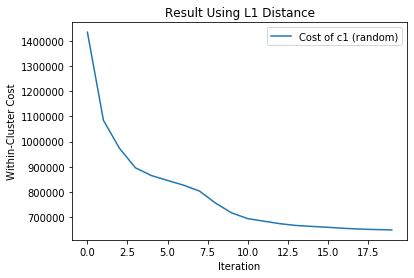

In [9]:
x = range(20)
plt.plot(x, L1_c1_wc_cost)
plt.legend(['Cost of c1 (random)'])
plt.title("Result Using L1 Distance")
plt.xlabel('Iteration')
plt.ylabel('Within-Cluster Cost')
plt.show()

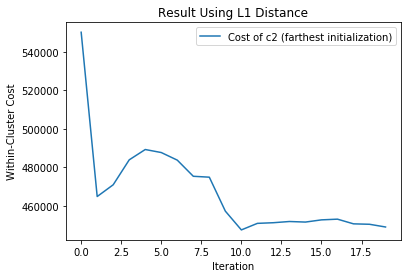

In [10]:
x = range(20)
plt.plot(x, L1_c2_wc_cost)
plt.legend(['Cost of c2 (farthest initialization)'])
plt.title("Result Using L1 Distance")
plt.xlabel('Iteration')
plt.ylabel('Within-Cluster Cost')
plt.show()

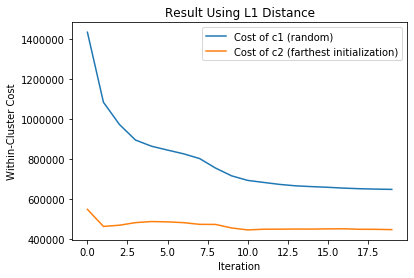

In [11]:
x = range(20)
plt.plot(x, L1_c1_wc_cost)
plt.plot(x, L1_c2_wc_cost)
plt.legend(['Cost of c1 (random)', 'Cost of c2 (farthest initialization)'])
plt.title("Result Using L1 Distance")
plt.xlabel('Iteration')
plt.ylabel('Within-Cluster Cost')
plt.show()

## (2). Using L2 distance as similarity measurement

In [12]:
L2_c1_combo, L2_c1_centroid, L2_c1_wc_cost = kmeans(data, centroids1, norm=2)

438747790.027918
249803933.62600294
194494814.40631396
169804841.45154333
156295748.80627596
149094208.10896605
142508531.61961588
132303869.40653005
117170969.83719079
108547377.17857017
102237203.31799614
98278015.74975717
95630226.12177445
93793314.05119292
92377131.96821107
91541606.25423913
91045573.83042422
90752240.10140836
90470170.18122767
90216416.17563146


In [13]:
L2_c2_combo, L2_c2_centroid, L2_c2_wc_cost = kmeans(data, centroids2, norm=2)

623660345.3064235
509862908.29754597
485480681.87200826
463997011.6850107
460969266.572994
460537847.98277014
460313099.65354246
460003523.88940686
459570539.3177353
459021103.3422901
458490656.1919808
457944232.5879742
457558005.1986796
457290136.3523032
457050555.0595639
456892235.61535746
456703630.7370357
456404203.0189769
456177800.54199505
455986871.02734846


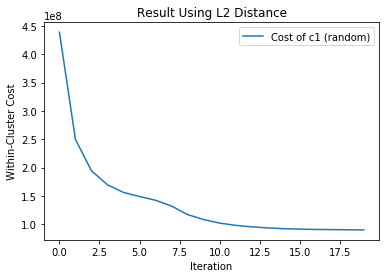

In [14]:
x = range(20)
plt.plot(x, L2_c1_wc_cost)
plt.legend(['Cost of c1 (random)'])
plt.title("Result Using L2 Distance")
plt.xlabel('Iteration')
plt.ylabel('Within-Cluster Cost')
plt.show()

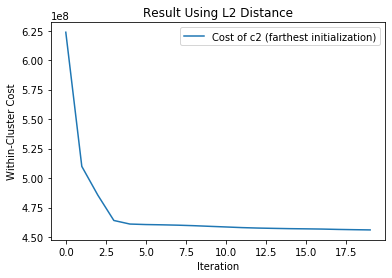

In [15]:
x = range(20)
plt.plot(x, L2_c2_wc_cost)
plt.legend(['Cost of c2 (farthest initialization)'])
plt.title("Result Using L2 Distance")
plt.xlabel('Iteration')
plt.ylabel('Within-Cluster Cost')
plt.show()

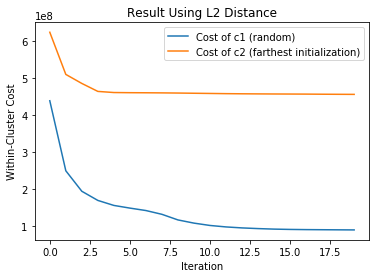

In [16]:
x = range(20)
plt.plot(x, L2_c1_wc_cost)
plt.plot(x, L2_c2_wc_cost)
plt.legend(['Cost of c1 (random)', 'Cost of c2 (farthest initialization)'])
plt.title("Result Using L2 Distance")
plt.xlabel('Iteration')
plt.ylabel('Within-Cluster Cost')
plt.show()